# 1. Two-dimensional data
First we start by creating our nececarry inputs

In [3]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

Create three different sized datasets and save them in a dictionary

In [4]:
# Create the moon datasets of varying sizes
n_samples_small = 100
n_samples_medium = 500
n_samples_large = 1000

datasets = {
    "Small": make_moons(n_samples=n_samples_small, noise=0.1, random_state=0),
    "Medium": make_moons(n_samples=n_samples_medium, noise=0.1, random_state=0),
    "Large": make_moons(n_samples=n_samples_large, noise=0.1, random_state=0),
}

Lets start by implementing and training our 2D Histogram

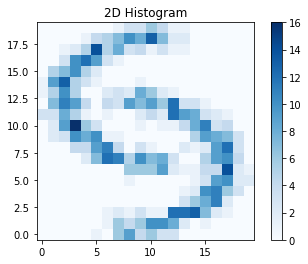

In [6]:
def train_histogram(X, y, bins=20):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    x_bins = np.linspace(x_min, x_max, bins + 1)
    y_bins = np.linspace(y_min, y_max, bins + 1)
    
    histogram = np.histogram2d(X[:, 0], X[:, 1], bins=[x_bins, y_bins])[0]
    
    return histogram

# Train histogram for a specific dataset (e.g., the small one)
X_small, y_small = datasets["Large"]
histogram_small = train_histogram(X_small, y_small)

# You can visualize the histogram if needed
plt.imshow(histogram_small, origin='lower', cmap='Blues')
plt.colorbar()
plt.title('2D Histogram')
plt.show()

# 2. Higher-dimensional data

## Loading and splitting the data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

Let's load the dataset and split in train and test set:

In [3]:
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2)

## Define Maximum Mean Discrepancy

In [162]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "rbf" or "inverse-multi-quadratic"
    """
    # Compute squared Euclidean distances

    xx, yy, zz = np.dot(x, x.T), np.dot(y, y.T), np.dot(x, y.T)
    rx = np.diag(xx).reshape(1, -1).repeat(xx.shape[0], axis=0)
    ry = np.diag(yy).reshape(1, -1).repeat(yy.shape[0], axis=0)

    dxx = rx.T + rx - 2. * xx  # Used for A in (1)
    dyy = ry.T + ry - 2. * yy  # Used for B in (1)
    dxy = rx.T + ry - 2. * zz  # Used for C in (1)

    XX, YY, XY = (np.zeros_like(xx), 
                  np.zeros_like(xx), 
                  np.zeros_like(xx))
    
    # Squared Exponential or Gaussian Kernel
    if kernel == "rbf":
        #bandwidth_range = [10, 15, 20, 50,100]
        bandwidth_range = [10, 15, 20, 25, 30]
        XX = sum(np.exp(-0.5 * dxx / a) for a in bandwidth_range)
        YY = sum(np.exp(-0.5 * dyy / a) for a in bandwidth_range)
        XY = sum(np.exp(-0.5 * dxy / a) for a in bandwidth_range)

    # Inverse Multi-Quadratic Kernel
    if kernel == "inverse-multi-quadratic":
        #bandwidth_range = [10, 15, 20, 50,100]
        bandwidth_range = [10, 15, 20, 25, 30]
        XX = sum(1 / (dxx / a + 1) for a in bandwidth_range)
        YY = sum(1 / (dyy / a + 1) for a in bandwidth_range)
        XY = sum(1 / (dxy / a + 1) for a in bandwidth_range)

    return np.mean(XX + YY - 2. * XY)

## Single Gaussian
Now we implement a single Gaussian model, by using the 'GaussianMixture' model from scikit-learn with just one component

In [158]:
n_components = 1
single_gaussian = GaussianMixture(n_components=n_components)
single_gaussian.fit(X_train)

GaussianMixture()

In [163]:
new_samples, _ = single_gaussian.sample(len(X_test))
result_rbf = MMD(X_test,new_samples, "rbf")
result_inv = MMD(X_test,new_samples, "inverse-multi-quadratic")

print(f"MMD with squared exponential kernel: {result_rbf.item()}")
print(f"MMD with inverse multi quadratic kernel: {result_inv.item()}")

MMD with squared exponential kernel: 0.02785815618230334
MMD with inverse multi quadratic kernel: 0.030277909540340285


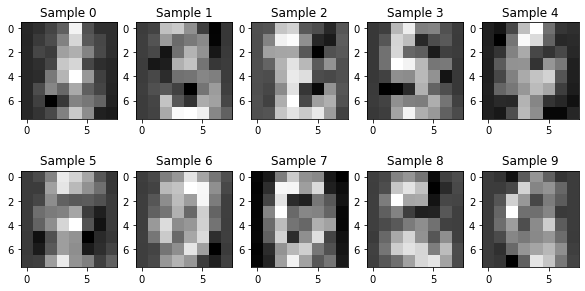

In [142]:
new_samples, _ = single_gaussian.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(new_samples[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Sample {i}")
plt.show()

## Gaussian mixture model (GMM)
Let's continue with training a Gaussian mixture model (GMM)

In [160]:
n_components = 50
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X_train)

GaussianMixture(n_components=50)

In [164]:
new_samples, _ = gmm.sample(len(X_test))
result_rbf = MMD(X_test,new_samples, "rbf")
result_inv = MMD(X_test,new_samples, "inverse-multi-quadratic")

print(f"MMD with squared exponential kernel: {result_rbf.item()}")
print(f"MMD with inverse multi quadratic kernel: {result_inv.item()}")

MMD with squared exponential kernel: 0.02785362832036542
MMD with inverse multi quadratic kernel: 0.028455976404273813


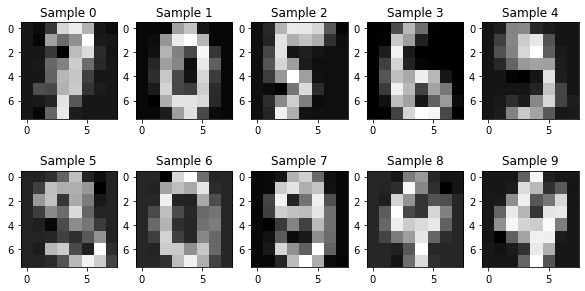

In [50]:
new_samples, _ = gmm.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(new_samples[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Sample {i}")
plt.show()

## Kernel Density Estimator (KDE)

Now we implement a kernel density estimator (KDE) with squared exponential kernel

In [138]:
from sklearn.neighbors import KernelDensity
bandwidth = 1.0
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(X_train)

KernelDensity()

In [156]:
new_samples = kde.sample(len(X_test))
result_rbf = MMD(X_test,new_samples, "rbf")
result_inv = MMD(X_test,new_samples, "inverse-multi-quadratic")

print(f"MMD with squared exponential kernel: {result_rbf.item()}")
print(f"MMD with inverse multi quadratic kernel: {result_inv.item()}")

MMD with squared exponential kernel: 0.03911116940514489
MMD with inverse multi quadratic kernel: 0.039472374222752564


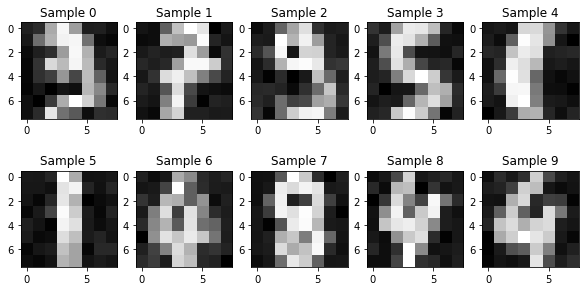

In [97]:
new_samples = kde.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(new_samples[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"Sample {i}")
plt.show()

## Random Forest Classifier
Finally we implement a Random forest classifier on the original dataset to destinguish the 10 digits. Further we will use this classifier to check if the models are working reasonably and that the 10 digits are generated in equal proportion

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

Accuracy on the test data: 0.98


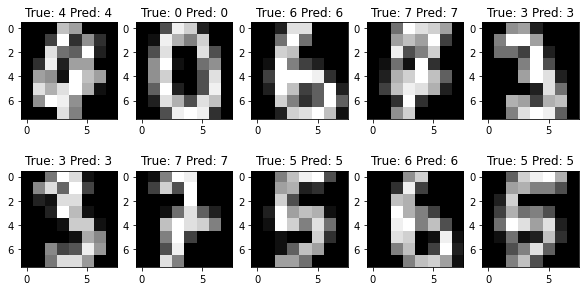

In [44]:
from sklearn.metrics import accuracy_score

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test data: {accuracy:.2f}")
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_test[i].reshape(8, 8), cmap=plt.cm.gray)
    ax.set_title(f"True: {y_test[i]} Pred: {y_pred[i]}")
plt.show()